# Prediction of the utilization using Neural Networks

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
from keras import Sequential
from keras.layers import Dense, Dropout

%matplotlib inline

## Read in the preprocessed data

In [2]:
Input_hourly = pd.read_csv('input_hourly.csv', parse_dates=['date'])
Input_hourly.info()
Input_hourly

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12235 entries, 0 to 12234
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   time_id                       12235 non-null  int64         
 1   date                          12235 non-null  datetime64[ns]
 2   site1_utilization_percentage  12235 non-null  float64       
 3   site2_utilization_percentage  12235 non-null  float64       
 4   temperature                   12235 non-null  float64       
 5   precipitation                 12235 non-null  float64       
 6   day_0                         12235 non-null  bool          
 7   day_1                         12235 non-null  bool          
 8   day_2                         12235 non-null  bool          
 9   day_3                         12235 non-null  bool          
 10  day_4                         12235 non-null  bool          
 11  day_5                       

,time_id,date,site1_utilization_percentage,site2_utilization_percentage,temperature,precipitation,day_0,day_1,day_2,day_3,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,6726,2018-10-08,5.77,11.11,13.000000,0.0,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,6727,2018-10-08,36.54,18.52,14.333333,0.0,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,6728,2018-10-08,36.54,48.15,17.000000,0.0,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,6729,2018-10-08,36.54,66.67,18.000000,0.0,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,6730,2018-10-08,36.54,61.11,20.000000,0.0,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12230,18956,2020-02-29,0.00,0.00,14.000000,0.0,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
12231,18957,2020-02-29,0.00,0.00,14.000000,0.0,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
12232,18958,2020-02-29,0.00,0.00,13.000000,0.0,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
12233,18959,2020-02-29,0.00,0.00,13.000000,0.0,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [3]:
# split into input and output
X = Input_hourly.drop(["time_id", "date", "site1_utilization_percentage", "site2_utilization_percentage"], axis=1)
y_site1 = Input_hourly["site1_utilization_percentage"]

# cross-validation
X_train, X_test, y_train_site1, y_test_site1 = train_test_split(X, y_site1, test_size=0.3)

# normalize the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

## Model definition

In [4]:
model = Sequential(
    [Dense(36, activation="relu", input_shape=[X_train.shape[1]]),
    Dense(36, activation="relu"),
     Dense(1)])
model.compile(loss='mse',
             optimizer="adam",
             metrics=["mae", "mse"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 36)                1656      
                                                                 
 dense_1 (Dense)             (None, 36)                1332      
                                                                 
 dense_2 (Dense)             (None, 1)                 37        
                                                                 
Total params: 3,025
Trainable params: 3,025
Non-trainable params: 0
_________________________________________________________________


## Training the model

In [5]:
epochs = 20

history = model.fit(X_train, y_train_site1.values,
                   epochs=epochs, validation_split=0.2)

Epoch 1/20
215/215 [==============================] - 2s 5ms/step - loss: 533.0542 - mae: 13.8805 - mse: 533.0542 - val_loss: 243.1818 - val_mae: 10.8183 - val_mse: 243.1818
Epoch 2/20
215/215 [==============================] - 1s 3ms/step - loss: 153.1343 - mae: 8.0189 - mse: 153.1343 - val_loss: 139.8717 - val_mae: 7.0406 - val_mse: 139.8717
Epoch 3/20
215/215 [==============================] - 1s 3ms/step - loss: 107.3984 - mae: 6.0802 - mse: 107.3984 - val_loss: 127.4000 - val_mae: 6.1021 - val_mse: 127.4000
Epoch 4/20
215/215 [==============================] - 1s 3ms/step - loss: 97.3072 - mae: 5.3790 - mse: 97.3072 - val_loss: 123.1592 - val_mae: 5.4719 - val_mse: 123.1592
Epoch 5/20
215/215 [==============================] - 1s 3ms/step - loss: 93.6988 - mae: 4.9478 - mse: 93.6988 - val_loss: 123.5144 - val_mae: 5.2237 - val_mse: 123.5144
Epoch 6/20
215/215 [==============================] - 1s 3ms/step - loss: 91.5824 - mae: 4.7578 - mse: 91.5824 - val_loss: 121.7203 - val_mae:

In [6]:
history_df = pd.DataFrame(history.history)
history_df

,loss,mae,mse,val_loss,val_mae,val_mse
0,533.054199,13.880457,533.054199,243.181778,10.818343,243.181778
1,153.134308,8.018883,153.134308,139.871750,7.040628,139.871750
2,107.398399,6.080228,107.398399,127.400002,6.102086,127.400002
3,97.307243,5.379014,97.307243,123.159241,5.471890,123.159241
4,93.698807,4.947820,93.698807,123.514381,5.223702,123.514381
5,91.582359,4.757808,91.582359,121.720337,5.045169,121.720337
6,90.459160,4.661831,90.459160,121.323975,5.014611,121.323975
7,89.878700,4.588826,89.878700,118.020477,4.989211,118.020477
8,89.554123,4.567225,89.554123,116.803070,5.055974,116.803070
9,88.851562,4.583449,88.851562,117.963753,4.981682,117.963753


In [7]:
root_metrics_df = history_df[["mse", "val_mse"]].apply(np.sqrt)
root_metrics_df.rename({"mse":"rmse", "val_mse":"val_rmse"}, axis=1, inplace=True)
root_metrics_df

,rmse,val_rmse
0,23.087967,15.594287
1,12.374745,11.826739
2,10.363320,11.287161
3,9.864443,11.097713
4,9.679814,11.113702
5,9.569867,11.032694
6,9.511002,11.014716
7,9.480438,10.863723
8,9.463304,10.807547
9,9.426111,10.861112


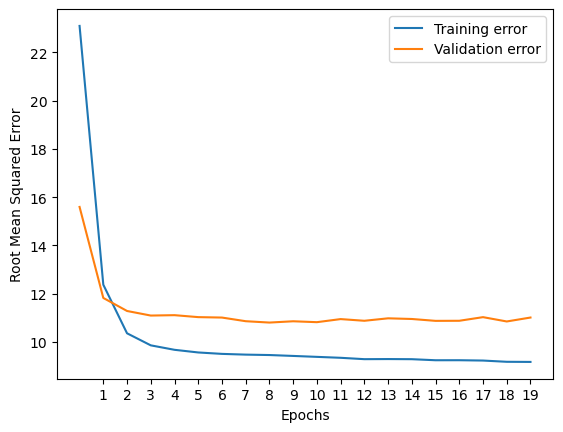

In [8]:
plt.Figure(figsize=(14,6), dpi=100)

plt.plot(root_metrics_df["rmse"], label = 'Training error')
plt.plot(root_metrics_df["val_rmse"], label = 'Validation error')

plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")

# plt.xlim([0, epochs])
plt.xticks(range(1,20))
plt.legend()

plt.show()

## Prediction

In [9]:
# normalize test data
X_test = scaler.transform(X_test)

# prediction using the trained model
y_pred_site1 = model.predict(X_test)

115/115 [==============================] - 0s 2ms/step


## Evaluation

In [10]:
print("RMSE: ", np.sqrt(mean_squared_error(y_test_site1, y_pred_site1)))
print("MAE: ", mean_absolute_error(y_test_site1, y_pred_site1))

RMSE:  10.23584785296401
MAE:  4.74068359606656
